Description: Spam Rate Predictions

Author: Elena (Chaoran) Gou

Last Update: 08/14/2021

In [1]:
import pandas as pd
import numpy as np

import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

np.random.seed(2000)

/Users/egou/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
### Twilio brand colors: https://www.twilio.com/brand/resources/colorresources

# Primary Twilio brand colors
tw_red = '#F22F46'
night = '#001489'

# Secondary Twilio brand colors
blue = '#008CFF' # blue_50
green = '#36D576' # green_50
tangerine = '#F47C22' 
yellow = '#FFDD35' #yellow_40
purple = '#8C5BD8' #purple_50

# extended pallete
gray_30 = '#CACDD8' 
red_30 = '#f6b1b1' 
orange_30 = '#FAC2A0' 
green_30 = '#A2F6C3'
blue_30 = '#99CDFF'
purple_30 = '#C8AFF0'
gray_70 = '#4B5671'
red_70 = '#ad1111'
orange_70 = '#C35323'
green_70 = '#0E7C3A'
blue_70 = '#043CB5'
yellow_70 = '#C28E00'
purple_70 = '#5817BD'

teal = '#00BCD4'
mauve = '##DEA7E8'

charting_colors = [blue, green, tangerine, purple, yellow, tw_red, night, 
                   gray_30, red_30, blue_30, orange_30, green_30, purple_30,
                   gray_70, red_70, blue_70, orange_70, green_70, purple_70]

#'#FF5722', '#FA9950', '#FAD100', '#4CB04F', '#36D576', '#303F9F', '#2196F3', '#00BCD4', '#00E5FF', '#7B1FA2', '#7C4DFF', '#880E4F', '#DEA7E8', '#FF4081', '#9E9E9E'


# Twilio fonts
fonts = ['Helvetica Neue', 'Helvetica', 'Arial', 'sans-serif']

# set colors and fonts
sns.set_style('ticks', {'axes.linewidth': 2., 'font.sans-serif': fonts, 'font.family': 'Helvetica Neue'})
plt.rc('figure', figsize=(16, 10))
sns.set_context('poster', font_scale=1.0)
sns.set_palette(charting_colors)

In [3]:
account = pd.read_csv('feature_engineered_May.csv')
account.head()

,attempted,account_sid,delivered,optouts,_7726,unreachable,_30007,_30008,_21610,aup,...,friendly_name,default_name,optout_perc,_7726_perc,_30008_perc,_30007_perc,_21610_perc,unreachable_perc,aup_perc,fraud_perc
0,291830197,AC0c4da9c0a8c20ea8890c2ca186768bed,279827613.0,0.0,383.0,10232167,677429,671412,3538,0.0,...,us-east-1,0.0,0.000000,0.000001,0.002301,0.002321,0.000012,0.035062,0.0,0.0
1,770805,ACbdccf1d7b857189e72fdb51c878d34db,768406.0,0.0,0.0,1674,0,725,0,0.0,...,Samsung,0.0,0.000000,0.000000,0.000941,0.000000,0.000000,0.002172,0.0,0.0
2,92827,AC21e3df471603c934315eb61694a18ab2,90908.0,1.0,0.0,935,0,984,0,0.0,...,j.teichert@vivenu.com's Account,0.0,0.000011,0.000000,0.010600,0.000000,0.000000,0.010073,0.0,0.0
3,4682,AC4be872f5cb700cf41676089db563bbc9,4518.0,0.0,0.0,158,3,2,0,0.0,...,Meevo M2NA0_ T10713-Tenant: 45206,0.0,0.000000,0.000000,0.000427,0.000641,0.000000,0.033746,0.0,0.0
4,25605,AC4cac4fec76a9decc2838641318025fa6,22138.0,327.0,3.0,3432,9,26,0,0.0,...,k.morrisonhealthadvisor@gmail.com,0.0,0.014771,0.000136,0.001015,0.000351,0.000000,0.134036,0.0,0.0


In [4]:
june = pd.read_csv('feature_engineered_June.csv')
june.head()

,attempted,account_sid,delivered,optouts,_7726,cannabis,unreachable,_30007,_30008,_21610,...,_30008_perc,_30007_perc,_21610_perc,unreachable_perc,aup_perc,fraud_perc,age,parent,isv,fam_size
0,26038,AC9f3116fcac59b5b68a451cba28f5a731,23407.0,1354.0,1.0,0,15,0,2616,0,...,0.100469,0.000000,0.000000,0.000576,0.0,0.0,5,1,1,682
1,536793,AC06ea2a0e2f80d342b45f46e42571dd02,504624.0,479.0,0.0,0,31670,183,316,0,...,0.000589,0.000341,0.000000,0.058999,0.0,0.0,68,0,0,3
2,2278,AC9d6d9155f700898c3f4fb05c4e90188b,2240.0,0.0,0.0,0,4,0,27,0,...,0.011853,0.000000,0.000000,0.001756,0.0,0.0,31,0,0,1
3,22281,ACac15107fc288db00551d7d26bc4cc764,19295.0,132.0,0.0,0,1191,0,266,1475,...,0.011938,0.000000,0.066200,0.053454,0.0,0.0,68,0,0,7
4,550054,AC55880b122abfcb40df3510b02f02ed9e,521606.0,0.0,0.0,0,27300,1,582,142,...,0.001058,0.000002,0.000258,0.049631,0.0,0.0,20,1,1,82


### Decision Tree

In [5]:
feature_perc = ['age','isv','parent','unreachable_perc','default_name',
       '_30007_perc', '_21610_perc', '_30008_perc', 
       'aup_perc','fraud_perc','cannabis','fam_size']

In [6]:
#Train test split
train, test = train_test_split(account, test_size=0.3)
x_train = train[feature_perc]
y_train = train['_7726_perc']

x_test = test[feature_perc]
y_test = test['_7726_perc']

#Create prediction data
X=june[feature_perc]
y=june['_7726_perc']

#Generate values to calculate mean RMSE
y_bar = [y.mean()]*len(y)
train_bar = [y_train.mean()]*len(y_train)
test_bar = [y_test.mean()]*len(y_test)

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

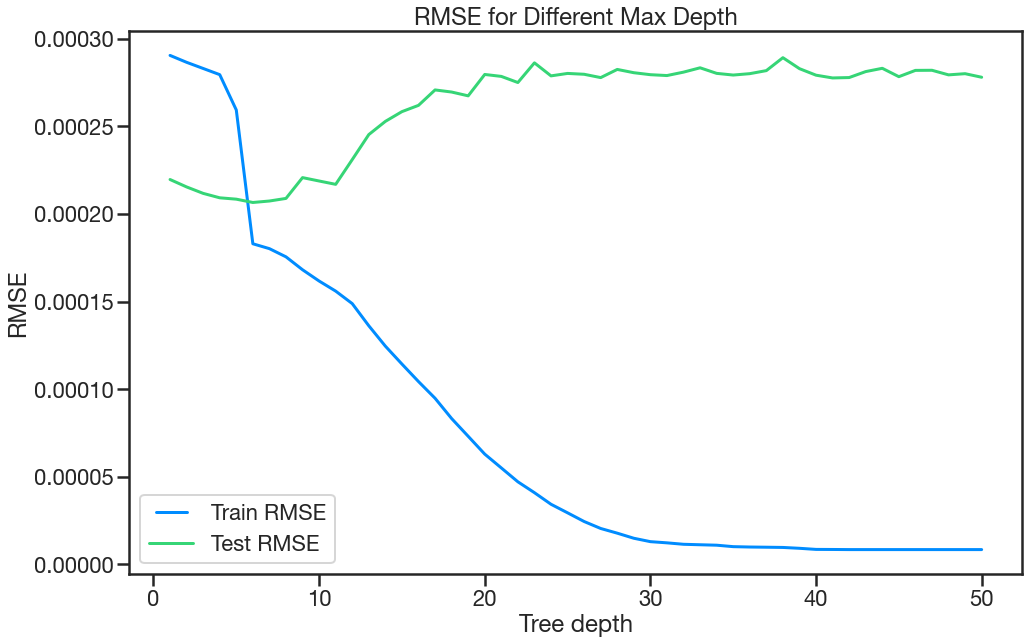

In [7]:
index = np.linspace(1, 50, 50, endpoint=True)
result = pd.DataFrame(index = index, columns=('train_results', 'test_results'))
for max_depth in index:
   dt = DecisionTreeRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   # Add rmse
   result.at[max_depth,'train_results']=np.sqrt(metrics.mean_squared_error(y_train, train_pred))
   test_pred = dt.predict(x_test)
   result.at[max_depth,'test_results']=np.sqrt(metrics.mean_squared_error(y_test, test_pred))

# Plotting RMSE for different tree depths
line1, = plt.plot(index, result['train_results'], label='Train RMSE')
line2, = plt.plot(index, result['test_results'], label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('RMSE for Different Max Depth')
plt.ylabel('RMSE')
plt.xlabel('Tree depth')
plt.show()

In [9]:
result['test_results'] = pd.to_numeric(result['test_results'])
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
optimal_dep = result['test_results'].idxmin()
print("Optimal Max Depth: ",optimal_dep)
print("Smallest RMSE: ",min(result['test_results']))

Root Mean Squared Error w mean: 0.00011354923989481513
Optimal Max Depth: 6
Smallest RMSE: 0.00020655647237283995


In [27]:
#Tree depth of 6 has the best result
regr = tree.DecisionTreeRegressor(max_depth=optimal_dep,random_state=0)
regr.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=6, random_state=0)

In [28]:
#R-squared
regr.score(x_train,y_train)

0.6923676270999933

In [29]:
regr.score(x_test,y_test)

0.10937147854419182

In [30]:
feature_importance = pd.DataFrame({"feature": x_test.columns,
                                 "importance": model.feature_importances_})
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
0,age,0.456613
5,_30007_perc,0.357876
11,fam_size,0.145153
3,unreachable_perc,0.033268
7,_30008_perc,0.005838
6,_21610_perc,0.001252
1,isv,0.000000
2,parent,0.000000
4,default_name,0.000000
8,aup_perc,0.000000


In [37]:
#Predict June opt-out rate and view top 10 predicted values
def get_top(predicted):
    june[predicted]=regr.predict(X)
    return june.sort_values(by=string,ascending=False)[['account_sid','_7726_perc',predicted]].head(10)

In [32]:
get_top('dt_perc_predict')

,account_sid,_7726_perc,dt_perc_predict
35311,ACca49e3fa4cc1f8f64986b367f45e3e40,0.000751,0.005822
71647,ACd34d91494f6a3146d51f63e61fbc8823,0.000000,0.005822
73760,ACab7f477d1d1160483e3b01c6753b6497,0.000000,0.005822
13953,ACeda0ffe3e5041d8af064613d8028453d,0.000000,0.005822
6418,ACf74a79587005dc72e52fb3b5ee60dd09,0.000000,0.000822
36633,ACe14f38b5f7a6f805ebecaf85406ef5a6,0.000000,0.000822
80753,ACc37a639438238c61d8a9d4d2f0f2a6b2,0.000000,0.000822
59775,ACf881114f0edf2b0b7174706a11428af7,0.000000,0.000822
4304,ACf8ea777647f602198dbe6f240b749f01,0.000000,0.000822
928,AC062868385c598d0b8b1f442ce8961103,0.000000,0.000822


### Random Forest

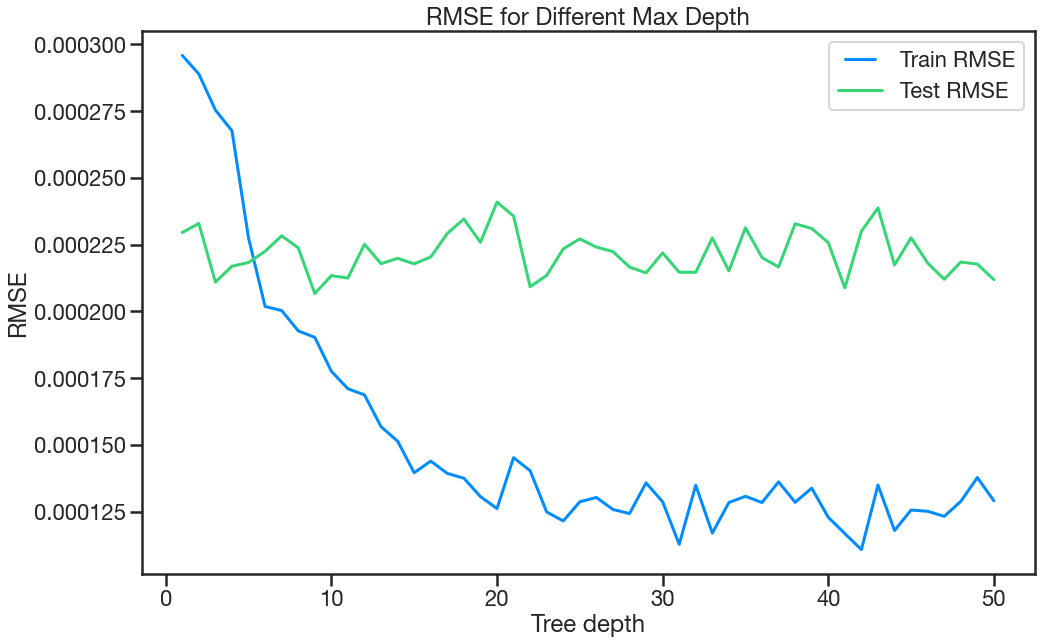

In [20]:
index = np.linspace(1, 50, 50, endpoint=True)
result = pd.DataFrame(index = index, columns=('train_results', 'test_results'))
for max_depth in index:
   dt = RandomForestRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   # Add rmse
   result.at[max_depth,'train_results']=np.sqrt(metrics.mean_squared_error(y_train, train_pred))
   test_pred = dt.predict(x_test)
   result.at[max_depth,'test_results']=np.sqrt(metrics.mean_squared_error(y_test, test_pred))

# Plotting RMSE for different tree depths
line1, = plt.plot(index, result['train_results'], label='Train RMSE')
line2, = plt.plot(index, result['test_results'], label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('RMSE for Different Max Depth')
plt.ylabel('RMSE')
plt.xlabel('Tree depth')
plt.show()

In [21]:
result['test_results'] = pd.to_numeric(result['test_results'])
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
optimal_dep = result['test_results'].idxmin()
print("Optimal Max Depth: ",optimal_dep)
print("Smallest RMSE: ",min(result['test_results']))

Root Mean Squared Error w mean: 0.00011354923989481513
Optimal Max Depth: 9
Smallest RMSE: 0.00020669250369513778


In [38]:
#Tree Depth of 9 has the best result
regr = RandomForestRegressor(max_depth=optimal_dep, random_state=0)
regr.fit(x_train,y_train)

RandomForestRegressor(max_depth=9, random_state=0)

In [39]:
regr.score(x_train,y_train)

0.6698708046751364

In [40]:
regr.score(x_test,y_test)

0.10904802772402422

In [41]:
feature_importance = pd.DataFrame({"feature": x_test.columns,
                                 "importance": regr.feature_importances_})
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
5,_30007_perc,5.404291e-01
3,unreachable_perc,1.822067e-01
11,fam_size,1.037275e-01
0,age,7.147848e-02
7,_30008_perc,4.948543e-02
1,isv,3.811114e-02
9,fraud_perc,6.631772e-03
6,_21610_perc,5.379744e-03
2,parent,1.996786e-03
8,aup_perc,5.533955e-04


In [42]:
get_top('rf_perc_predict')

,account_sid,_7726_perc,rf_perc_predict
13176,AC1ffec11541a5dcd1fda1a1e4e96534f1,0.000000,0.006591
25108,AC14989656923108dbffbca1a5d12ef7ca,0.000000,0.006516
55385,ACef92e31dbda19ffff56ff0bd0f0f0313,0.000000,0.006477
12021,AC2dbe95b91c614a64f7cf87b280020220,0.000000,0.005985
8864,ACde36d90ff7d955da49c313dfc67ce8d7,0.000000,0.003897
16749,AC671638e22b4e2c4ec98de2aae4dd3e44,0.000478,0.003570
73042,AC45909a898b64f088a1f2042a57f183a0,0.000000,0.003291
44367,ACc8dfc2d3fe4f11d0f3a422d61dd1959c,0.000000,0.002178
40510,ACe9ba035194867bc1c28abc95653f5c96,0.000000,0.002065
10675,AC1632ec963958997f96abb8bfc765665f,0.000000,0.002016


### KNN 

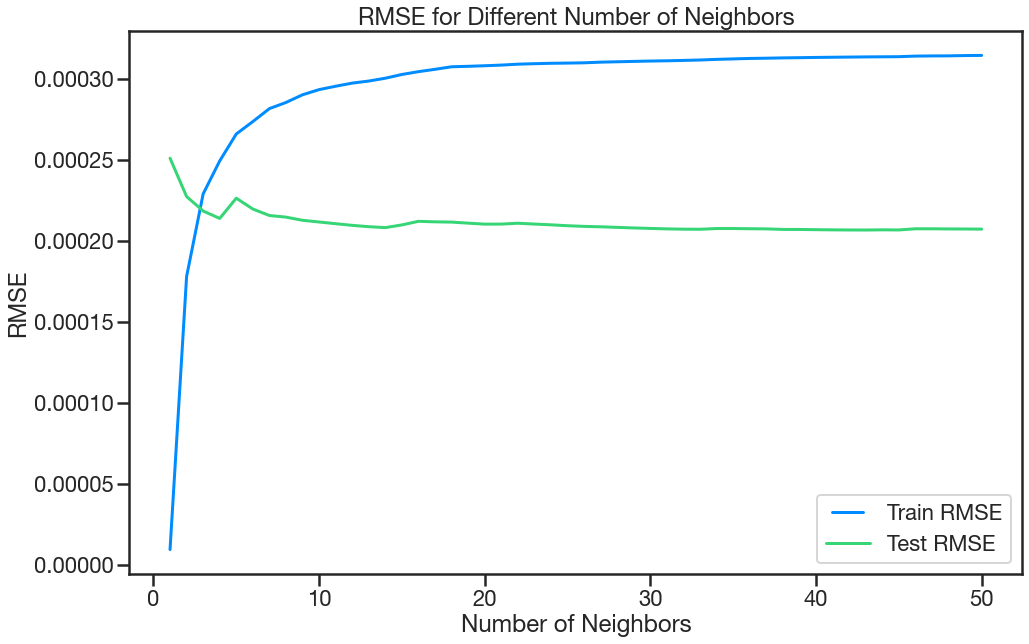

In [43]:
index = np.linspace(1, 50, 50, endpoint=True)
result = pd.DataFrame(index = index, columns=('train_results', 'test_results'))
for n in index:
   dt = KNeighborsRegressor(n_neighbors=int(n))
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   # Add rmse
   result.at[n,'train_results']=np.sqrt(metrics.mean_squared_error(y_train, train_pred))
   test_pred = dt.predict(x_test)
   result.at[n,'test_results']=np.sqrt(metrics.mean_squared_error(y_test, test_pred))

# Plotting RMSE for different tree depths
line1, = plt.plot(index, result['train_results'], label='Train RMSE')
line2, = plt.plot(index, result['test_results'], label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('RMSE for Different Number of Neighbors')
plt.ylabel('RMSE')
plt.xlabel('Number of Neighbors')
plt.show()

In [44]:
result['test_results'] = pd.to_numeric(result['test_results'])
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
optimal_dep = result['test_results'].idxmin()
print("Optimal Max Depth: ",optimal_dep)
print("Smallest RMSE: ",min(result['test_results']))

Root Mean Squared Error w mean: 0.00011354923989481513
Optimal Max Depth: 43
Smallest RMSE: 0.00020664660625112057


In [45]:
#k of 43 has the best result
regr = KNeighborsRegressor(n_neighbors=optimal_dep)
regr.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=43)

In [46]:
regr.score(x_train,y_train)

0.09680258131337915

In [47]:
regr.score(x_test,y_test)

0.11513684520360679

In [48]:
results = permutation_importance(regr, X, y, scoring='neg_mean_squared_error')
feature_importance = pd.DataFrame({"feature": x_test.columns,
                                 "importance": results.importances_mean})
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
11,fam_size,2.536812e-09
0,age,7.315996e-10
3,unreachable_perc,4.553546e-10
5,_30007_perc,6.239335e-11
7,_30008_perc,5.957752e-11
1,isv,2.455914e-12
8,aup_perc,4.668187e-14
4,default_name,0.000000e+00
10,cannabis,0.000000e+00
6,_21610_perc,-1.990448e-12


In [49]:
get_top('knn_perc_predict')

,account_sid,_7726_perc,knn_perc_predict
13176,AC1ffec11541a5dcd1fda1a1e4e96534f1,0.000000,0.006591
25108,AC14989656923108dbffbca1a5d12ef7ca,0.000000,0.006516
55385,ACef92e31dbda19ffff56ff0bd0f0f0313,0.000000,0.006477
12021,AC2dbe95b91c614a64f7cf87b280020220,0.000000,0.005985
8864,ACde36d90ff7d955da49c313dfc67ce8d7,0.000000,0.003897
16749,AC671638e22b4e2c4ec98de2aae4dd3e44,0.000478,0.003570
73042,AC45909a898b64f088a1f2042a57f183a0,0.000000,0.003291
44367,ACc8dfc2d3fe4f11d0f3a422d61dd1959c,0.000000,0.002178
40510,ACe9ba035194867bc1c28abc95653f5c96,0.000000,0.002065
10675,AC1632ec963958997f96abb8bfc765665f,0.000000,0.002016


### Neural Network

In [182]:
regr = MLPRegressor(solver='adam',random_state=0, activation='logistic',max_iter=5000).fit(x_train, y_train)

In [183]:
pred = regr.predict(X)

In [89]:
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, pred))

Root Mean Squared Error w mean: 0.00011354923989482196


0.00023784857684190346

In [184]:
regr.score(x_train,y_train)

-1.0175238815003733

In [185]:
regr.score(x_test,y_test)

-2.0579097517716796

In [186]:
get_top('nn_predict')

,account_sid,_7726_perc,nn_predict
8233,AC2308cf798f68e8b3d151257d30d7c645,0.0,0.010814
50335,AC174e855f25e24f76b83093221ab38ca3,0.0,0.008852
11808,ACaa81b6217e5f40fab4dd48581f858dcb,0.0,0.008773
62539,ACe63bf92982174786b9d10d9e764c3419,0.0,0.007961
63333,AC2871bb4cb7062c3d7aed3a66f330bc37,0.0,0.006668
61865,AC07859d36d29002c12683e31c3b305797,0.0,0.006414
48690,ACe5c60f5f013e460bbdc999c20843b485,0.0,0.005288
41875,AC7c2a6d3569175c0a08865b57dd9c91a6,0.0,0.005183
13377,ACac689c09ce794956a2ab991812221902,0.0,0.004877
18041,AC7548c1496a7ea8241557f30f55575f12,0.0,0.004673


### Bagging

In [192]:
regr = BaggingRegressor(base_estimator=SVR(kernel='sigmoid'),n_estimators=30, random_state=0).fit(x_train, y_train)

In [175]:
pred = regr.predict(X)

In [193]:
regr.score(x_train,y_train)

-3837.360595987094

In [194]:
regr.score(x_test,y_test)

-7758.9249825817515

In [177]:
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, pred))

Root Mean Squared Error w mean: 0.00011354923989482196


0.0001326419683157639

In [179]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
5,_30007_perc,0.493270
3,unreachable_perc,0.229605
7,_30008_perc,0.161022
0,age,0.053199
11,fam_size,0.053041
6,_21610_perc,0.005399
1,isv,0.002741
9,fraud_perc,0.001657
8,aup_perc,0.000065
2,parent,0.000000


In [191]:
get_top('bag_predict')

,account_sid,optout_perc,bag_predict
0,AC9f3116fcac59b5b68a451cba28f5a731,0.057846,0.01981
54054,ACc488c0c7e7fd3e86b6b63db13684f446,0.031795,0.01981
54061,AC6425bb29d25434b29b7ce1f3ab3aefa1,0.000000,0.01981
54060,AC94df3a63ffdf113aa8dc659db14926f1,0.000000,0.01981
54059,AC7936829b0f9f440e103988690b42e789,0.000000,0.01981
54058,ACcd48b9ad24d38648a6317bae06c12496,0.000000,0.01981
54057,AC411755b57bc46970e519caf1471a5181,0.008551,0.01981
54056,AC7700a06b86782199a0cc71fe3a5b2dde,0.001195,0.01981
54055,AC3bbb12f3461a45f1ffec25420bd45d41,0.000000,0.01981
54053,AC9580fdbe2945eb580cb3337ef0d9386f,0.000000,0.01981


### Boosting

In [153]:
reg = GradientBoostingRegressor(loss='huber',n_estimators=1000,random_state=0)
reg.fit(x_train, y_train)
predict = reg.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, predict))

Root Mean Squared Error w mean: 0.00011354923989482196


0.00011094062663826243

In [154]:
reg = GradientBoostingRegressor(loss='lad',n_estimators=1000,random_state=0)
reg.fit(x_train, y_train)
predict = reg.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, predict))

Root Mean Squared Error w mean: 0.00011354923989482196


0.00011502195840196244

In [160]:
#hyperparameter tuning
parameters = {
    'loss':('huber','lad'),
    'n_estimators':(30,40,50,60,70,100,200,300),
}
model = GridSearchCV(GradientBoostingRegressor(),parameters,cv=5)
model.fit(x_train, y_train)
model.best_score_,model.best_params_

(0.011669471633576723, {'loss': 'huber', 'n_estimators': 100})

In [161]:
#Re-train model with the best parameters
model = GradientBoostingRegressor(loss='huber',n_estimators=100)
model.fit(x_train,y_train)
predict = model.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, predict))

Root Mean Squared Error w mean: 0.00011354923989482196


0.00011072276564597601

In [163]:
#hyperparameter tuning
parameters = {
    'loss':('huber','lad'),
    'n_estimators':(30,40,50,60,70,100,200,300),
    'max_depth':(2,4,6,8)
}
model = GridSearchCV(GradientBoostingRegressor(),parameters,cv=5)
model.fit(x_train, y_train)
model.best_score_,model.best_params_

(0.030263389683138263, {'loss': 'lad', 'max_depth': 6, 'n_estimators': 70})

In [195]:
#Re-train model with the best parameters
model = GradientBoostingRegressor(loss='lad',n_estimators=70,max_depth=6)
model.fit(x_train,y_train)
predict = model.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, predict))

Root Mean Squared Error w mean: 0.00011354923989482196


0.00010969884955906693

In [181]:
feature_importance = pd.DataFrame({"feature": x_test.columns,
                                 "importance": model.feature_importances_})
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
5,_30007_perc,0.495272
3,unreachable_perc,0.240247
7,_30008_perc,0.156313
0,age,0.055688
11,fam_size,0.041643
6,_21610_perc,0.007013
1,isv,0.002269
9,fraud_perc,0.001556
2,parent,0.000000
4,default_name,0.000000


In [167]:
get_top('boosting_predict')

,account_sid,_7726_perc,boosting_predict
45871,AC2eee9d2fafa59aa8751561dee2804fd0,0.000607,0.000881
14723,AC351dcd0bf756313182985535ecb1e61d,0.000000,0.000881
39371,AC51eb06c6956ac18ae9277c2a6a653007,0.000000,0.000517
5892,AC47a1a26cabc786c93b8b8ccaec546f2b,0.000000,0.000517
53305,AC34ac9ce44c75687e9388d9b7ca0867d4,0.000000,0.000517
21705,AC037c11ea7e8d678dae7fc5700587598d,0.000000,0.000517
8899,AC627f706ebf22fc2ce7446f5782543b8f,0.000358,0.000491
67180,AC83ec10100f584c672f53e271a30438de,0.000335,0.000491
55287,AC7dcf916efa0cc5841a1c88db0d3036d0,0.000382,0.000490
26399,AC2f002ddf6bd758c09a4c9a38513db381,0.000648,0.000490
